# OpenKE embeddings in Wikidata
http://139.129.163.161/index/toolkits#

In [66]:
!pip install plotly

     |████████████████████████████████| 12.9 MB 8.7 MB/s eta 0:00:01
Processing /Users/kalyan/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c/retrying-1.3.3-cp37-none-any.whl


In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import os
import csv

## 1. get pretrained embeddings

In [2]:
ebd_folder = "/Volumes/Kalyan SSD/SMG/wikidata/wikidata-embeddings"

In [3]:
dimension = 50 # 50 or 100

# entity2vec
e_vec_path = os.path.join(ebd_folder, f"embeddings/dimension_{dimension}/transe/entity2vec.bin")
e_vec = np.memmap(e_vec_path, dtype='float32', mode='r')
e_vec = np.reshape(e_vec, (int(len(e_vec)/dimension), dimension))

# relation2vec
r_vec_path = os.path.join(ebd_folder, f"embeddings/dimension_{dimension}/transe/relation2vec.bin")
r_vec = np.memmap(r_vec_path, dtype='float32', mode='r')
r_vec = np.reshape(r_vec, (int(len(r_vec)/dimension), dimension))

In [4]:
len(e_vec[0])

50

In [5]:
# read entity2id
e_id_path = os.path.join(ebd_folder, 'knowledge graphs/entity2id.txt')
e_id = pd.read_csv(e_id_path, sep="\t")

r_id_path = os.path.join(ebd_folder, 'knowledge graphs/relation2id.txt')
r_id = pd.read_csv(r_id_path, sep="\t")

In [6]:
def get_entity_embedding(e):
    line = e_id.loc[e].values[0]
    return e_vec[line]

def get_relation_embedding(r):
    line = r_id.loc[r].values[0]
    return r_vec[line]

In [7]:
get_entity_embedding("Q4927524")

memmap([-0.125914,  0.088485,  0.119553,  0.174013,  0.061394,  0.091272,
         0.124144,  0.097085,  0.120775,  0.139818,  0.030657,  0.089032,
        -0.131159,  0.049675,  0.096869, -0.059853,  0.152072, -0.12257 ,
        -0.055633,  0.075722, -0.077843, -0.076973,  0.151009,  0.127656,
        -0.072852,  0.102942, -0.156124,  0.094558,  0.088865, -0.160707,
        -0.08848 ,  0.18633 ,  0.158739, -0.081811,  0.172876, -0.099272,
        -0.138118, -0.08567 ,  0.16715 ,  0.113179,  0.103198,  0.04362 ,
         0.129714,  0.122535, -0.155369,  0.047308, -0.118865, -0.113756,
        -0.183931,  0.123166], dtype=float32)

In [8]:
get_relation_embedding("P36") # capital

memmap([-2.39450e-02,  5.15610e-02, -1.70230e-02, -1.24171e-01,
        -1.40650e-02,  2.61030e-02,  3.13570e-02, -7.20310e-02,
        -1.80700e-03, -1.04070e-02,  4.16400e-02, -1.02706e-01,
        -7.70000e-04, -3.74400e-02, -1.80510e-02, -4.43130e-02,
        -1.06303e-01,  1.71470e-02,  6.35790e-02,  1.40000e-05,
        -6.22400e-02,  2.20210e-02, -6.73320e-02, -5.87320e-02,
         4.81850e-02, -2.93620e-02,  5.34210e-02,  9.46650e-02,
        -5.25390e-02,  1.60700e-03,  2.39790e-02, -5.94200e-03,
         1.69121e-01, -1.04627e-01, -9.73100e-03,  4.09700e-02,
         6.56380e-02, -1.09670e-02,  2.73960e-02,  5.04590e-02,
        -7.01660e-02, -2.27800e-02,  3.02480e-02,  4.35230e-02,
         5.54920e-02, -6.22430e-02,  5.02980e-02, -8.45620e-02,
         9.92470e-02, -5.47800e-03], dtype=float32)

In [9]:
capitalof_france = get_entity_embedding("Q142") + get_relation_embedding("P36")
paris = get_entity_embedding("Q90")
tokyo = get_entity_embedding("Q1490")
spaghetti = get_entity_embedding("Q20026")

print(f"france + capital - paris = {distance.cosine(capitalof_france, paris)}")
print(f"france + capital - tokyo = {distance.cosine(capitalof_france, tokyo)}")
print(f"france + capital - spaghetti = {distance.cosine(capitalof_france, spaghetti)}")

france + capital - paris = 0.4428873062133789
france + capital - tokyo = 0.6585524678230286
france + capital - spaghetti = 0.9654010757803917


In [82]:
capital = get_relation_embedding("P36")
capital_of = get_relation_embedding("P1376")

print(f"capital - capital of = {distance.cosine(capital, capital_of)}")

capital - capital of = 1.9864640831947327


## 2. plotting embeddings

In [67]:
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

/Users/kalyan/.local/share/virtualenvs/heritage-connector-tkmarX41/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [50]:
df = pd.read_pickle("../GITIGNORE_DATA/filtering_people_orgs_result.pkl")
df_links = df[df['qcodes_filtered'].apply(len) == 1]
len(df_links)

3714

In [55]:
failed = []
embeddings = []

for idx, row in tqdm(df_links.iterrows(), total=len(df_links)):
    try:
        embeddings.append( list(get_entity_embedding(row['qcodes_filtered'][0])) )
    except:
        embeddings.append( [] )
        failed.append(row['qcodes_filtered'][0])

print(f"{len(failed)}/{len(df_links)} failed")

df_links['embedding'] = [item for item in embeddings]


61/3714 failed


/Users/kalyan/.local/share/virtualenvs/heritage-connector-tkmarX41/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kalyan/.local/share/virtualenvs/heritage-connector-tkmarX41/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [65]:
df_links = df_links[df_links['embedding'].apply(len) == 50]
embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(df_links['embedding'].tolist())

df_links['X0'] = embeddings_2d[:,0]
df_links['X1'] = embeddings_2d[:,1]

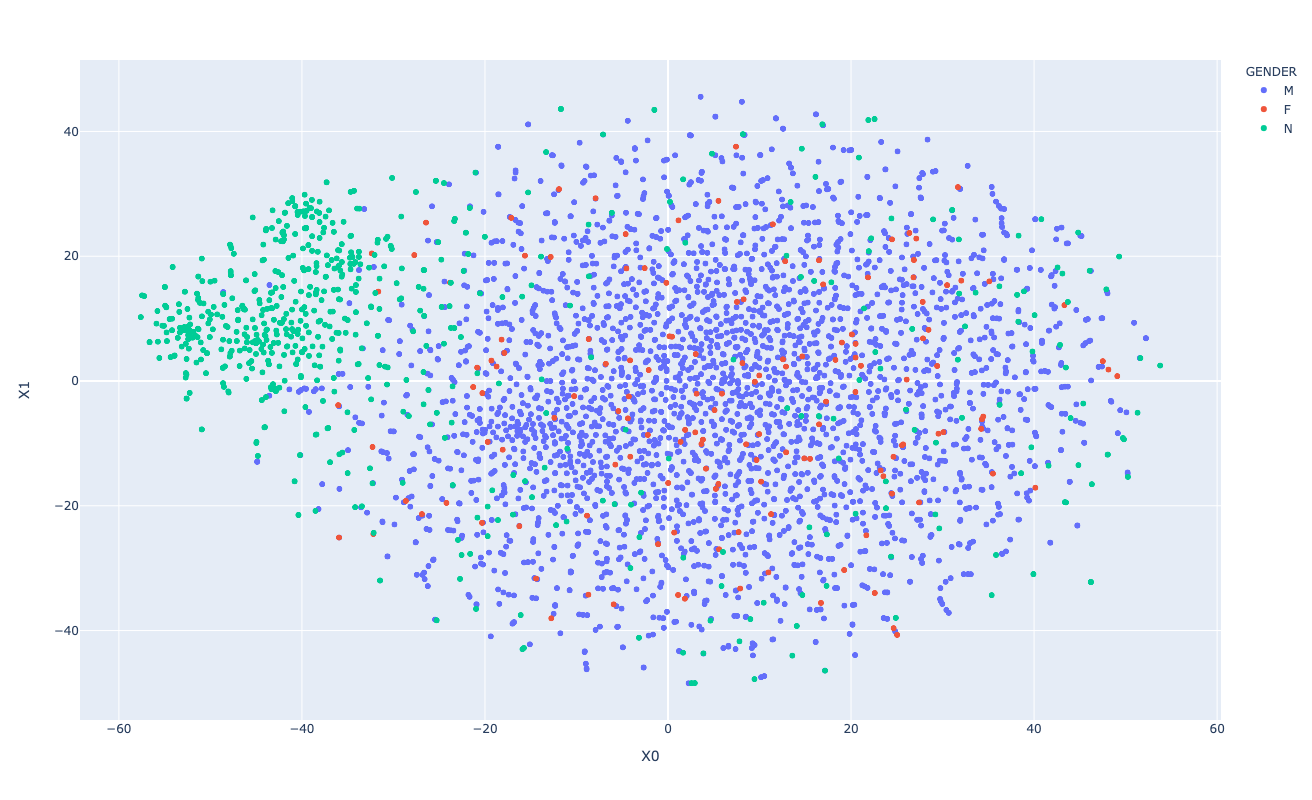

In [77]:
def plot_embeddings_pex(df):
    fig = px.scatter(df, x='X0', y='X1', hover_data=['PREFERRED_NAME', 'qcodes_filtered', 'NATIONALITY', 'OCCUPATION'], color="GENDER", width=1000, height=800)
    fig.show()
    
plot_embeddings_pex(df_links)